# Fake News Detection - Complete Project

This notebook includes:
- Data Preprocessing
- Simple Model (Naive Bayes with TF-IDF)
- Advanced Model (DistilBERT)
- Evaluation on FakeNewsCorpus and LIAR Dataset
- Saving & Loading Models

# Data Exploration and Preprocessing

In [2]:
import nltk
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter

# Download necessary NLTK datasets
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import sys
import pandas as pd
import csv
csv.field_size_limit(sys.maxsize)


CHUNK_SIZE = 100000  
SAMPLE_RATIO = 0.10 

sampled_chunks = []

for chunk in pd.read_csv("news.csv", usecols=["content"], dtype=str, encoding="utf-8",
                         on_bad_lines="skip", low_memory=True, chunksize=CHUNK_SIZE, engine="python"):
    chunk_sample = chunk.sample(frac=SAMPLE_RATIO, random_state=42)  
    sampled_chunks.append(chunk_sample)

# Combine all sampled chunks
df_sampled = pd.concat(sampled_chunks, ignore_index=True)

print(f" Final Sampled Dataset Size: {len(df_sampled)} rows")  

 Final Sampled Dataset Size: 852909 rows


In [ ]:

#calculation of vocab size before processing
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()


def get_vocabulary_size(text_series, chunk_size=5000):
    vocab = Counter()  
    for i in range(0, len(text_series), chunk_size):
        chunk_tokens = []
        
        # Tokenize 
        for text in text_series[i:i + chunk_size]:
            if text:  
                tokens = word_tokenize(text)  
                tokens = [token.lower() for token in tokens if token.isalpha()]  
                chunk_tokens.extend(tokens)  
        
        
        vocab.update(chunk_tokens)
    
    return len(vocab) 


vocab_size_before = get_vocabulary_size(df_sampled['content'])

print(f" Initial Vocabulary Size: {vocab_size_before}")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


 Initial Vocabulary Size: 1116207


In [ ]:
# Preprocessing or data cleaning
df_sampled = df_sampled.dropna(subset=['content'])


def preprocess_text(text):
    tokens = word_tokenize(text) 
    tokens = [token.lower() for token in tokens if token.isalpha()]  
    tokens = [token for token in tokens if token not in stop_words]  
    tokens = [stemmer.stem(token) for token in tokens]  
    return tokens


def get_vocabulary_size_processed(text_series, chunk_size=5000):
    vocab = Counter()
    for i in range(0, len(text_series), chunk_size):
        chunk_tokens = [preprocess_text(text) for text in text_series[i:i + chunk_size]]
        for tokens in chunk_tokens:
            vocab.update(tokens)
    return len(vocab)


vocab_size_after = get_vocabulary_size_processed(df_sampled['content'])

print(f" Vocabulary Size After Preprocessing: {vocab_size_after}")


 Vocabulary Size After Preprocessing: 969271


In [ ]:
import re

# Function to count URLs
def count_urls(text):
    return len(re.findall(r'http[s]?://\S+', text))


df_sampled['url_count'] = df_sampled['content'].apply(count_urls)

print(df_sampled['url_count'].describe())


count    852895.000000
mean          0.213242
std           1.360819
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         263.000000
Name: url_count, dtype: float64


In [ ]:
# Function to count dates
def count_dates(text):
    return len(re.findall(r'\b\d{1,2}[-/]\d{1,2}[-/]\d{2,4}\b', text))


df_sampled['date_count'] = df_sampled['content'].apply(count_dates)

print(df_sampled['date_count'].describe())


count    852895.000000
mean          0.050565
std           1.190655
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         376.000000
Name: date_count, dtype: float64


In [ ]:
# Function to count numeric values
def count_numbers(text):
    return len(re.findall(r'\b\d+\b', text))

df_sampled['num_count'] = df_sampled['content'].apply(count_numbers)


print(df_sampled['num_count'].describe())


count    852895.000000
mean          9.771909
std          31.807210
min           0.000000
25%           1.000000
50%           3.000000
75%          10.000000
max        3361.000000
Name: num_count, dtype: float64


In [8]:
total_urls = df_sampled["url_count"].sum()
total_dates = df_sampled["date_count"].sum()
total_numbers = df_sampled["num_count"].sum()

print(f"Total URLs: {total_urls}")
print(f"Total Dates: {total_dates}")
print(f"Total Numbers: {total_numbers}")



Total URLs: 181873
Total Dates: 43127
Total Numbers: 8334412


In [ ]:
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize


freq_dist_before = FreqDist()

chunk_size = 10000  

for i in range(0, len(df_sampled), chunk_size):
    chunk = df_sampled["content"][i : i + chunk_size].dropna()  
    chunk_tokens = [word_tokenize(text.lower()) for text in chunk] 
    chunk_tokens = [item for sublist in chunk_tokens for item in sublist]
    freq_dist_before.update(chunk_tokens)  

#  100 most frequent words
most_frequent_words = freq_dist_before.most_common(100)

print(most_frequent_words)


[('the', 22390490), (',', 20790074), ('.', 16200060), ('to', 10796151), ('of', 10672297), ('and', 9807935), ('a', 8440061), ('in', 7408707), ('that', 4844790), ('is', 4359395), ('’', 3943676), ('for', 3751516), ('it', 3086467), ('on', 2992349), ('“', 2489700), ('”', 2438757), ('with', 2423910), ('s', 2409243), ('as', 2396337), (':', 2252276), ('was', 2110288), ('are', 2102207), ('i', 2065048), ('by', 1996057), ('this', 1950347), ('you', 1916419), ('at', 1879479), ('not', 1873171), ('be', 1854972), ('he', 1853708), ('have', 1808569), (')', 1783509), ('(', 1755087), ('from', 1746446), ("''", 1500276), ('they', 1483941), ('an', 1477583), ('has', 1471067), ('we', 1443458), ("'s", 1439755), ('but', 1407498), ('his', 1392768), ('or', 1290622), ('said', 1218521), ('``', 1186647), ('who', 1155390), ('will', 1135401), ('their', 1086035), ('all', 991414), ('more', 989730), ('about', 947431), ('?', 920360), ('one', 917715), ('new', 908391), ('can', 894249), ('which', 874364), ('if', 849899), ('wo

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer
import string

# Load English stopwords and punctuation
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

freq_dist = FreqDist()
stemmer = PorterStemmer()


chunk_size = 10000  


for i in range(0, len(df_sampled), chunk_size):
    chunk = df_sampled["content"][i : i + chunk_size].dropna()  
    chunk_tokens = [word_tokenize(text.lower()) for text in chunk]  
    
   
    chunk_tokens = [item for sublist in chunk_tokens for item in sublist]  
    
   
    filtered_tokens = [
        stemmer.stem(word)  
        for word in chunk_tokens
        if word.isalpha() and word not in stop_words and word not in punctuation
    ]
    

    freq_dist.update(filtered_tokens)  

#  100 most frequent words after preprocessing
most_frequent_words = freq_dist.most_common(100)

#  100 most frequent words
print(most_frequent_words)


[('said', 1218535), ('one', 957890), ('new', 908562), ('would', 836596), ('time', 827155), ('state', 801855), ('year', 783373), ('peopl', 755543), ('like', 720122), ('use', 604798), ('also', 592218), ('us', 557397), ('make', 533384), ('say', 512913), ('go', 500536), ('get', 496334), ('even', 488537), ('presid', 458326), ('govern', 458183), ('american', 445926), ('work', 444421), ('report', 439072), ('right', 435436), ('nation', 430620), ('could', 430451), ('first', 427957), ('two', 423061), ('day', 421740), ('trump', 419425), ('news', 418016), ('mani', 417934), ('come', 416948), ('obama', 410792), ('continu', 391564), ('world', 389418), ('take', 389185), ('stori', 386862), ('may', 383698), ('read', 378005), ('call', 373205), ('last', 373199), ('want', 363934), ('see', 363062), ('includ', 354478), ('know', 352014), ('think', 351412), ('way', 349348), ('countri', 341515), ('back', 339537), ('need', 334487), ('public', 332417), ('support', 326465), ('polit', 319836), ('unit', 310616), ('t

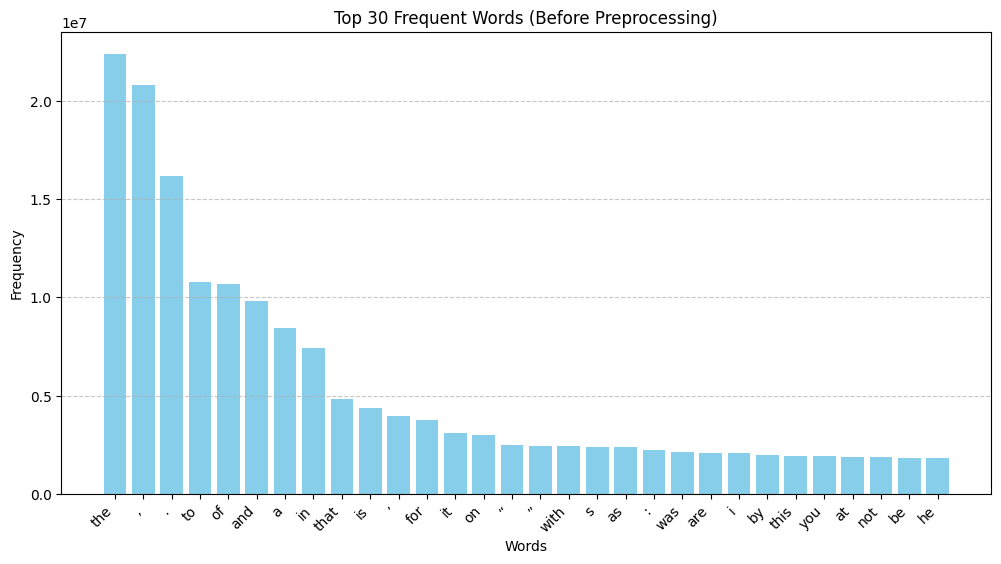

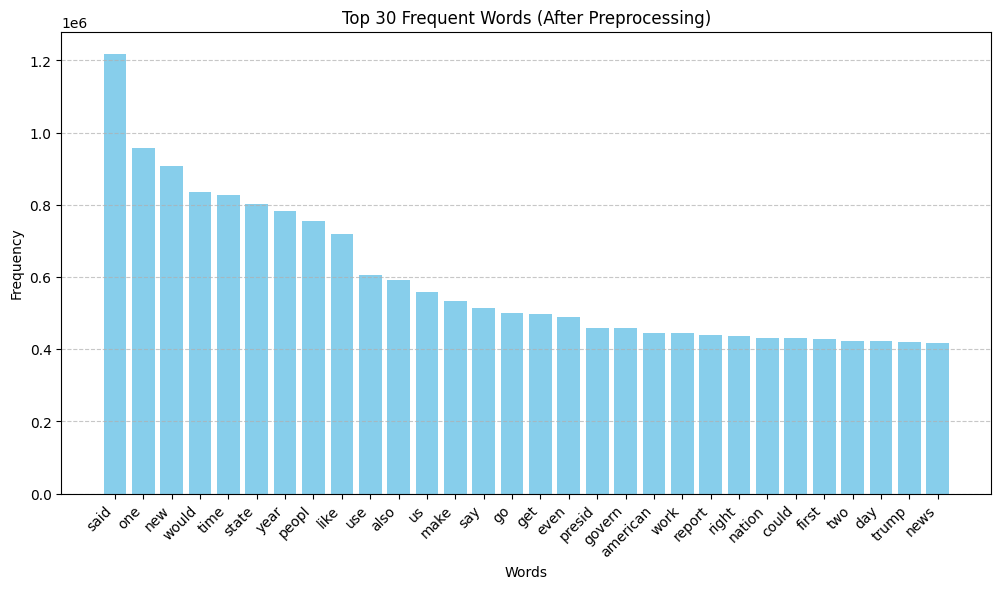

In [ ]:
import matplotlib.pyplot as plt

# Function to plot word frequencies
def plot_word_frequencies(freq_dist, title):
    if not freq_dist or len(freq_dist) == 0:
        print(f"Warning: No words available for {title}")
        return
    
    
    most_common_words = freq_dist.most_common(30)
    words, counts = zip(*most_common_words)  
    
    #  plot
    plt.figure(figsize=(12, 6))
    plt.bar(words, counts, color='skyblue')
    plt.xticks(rotation=45, ha='right')  
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.grid(axis='y', linestyle='--', alpha=0.7)  
    plt.show()

# Plotting the 30 most frequent words before preprocessing
plot_word_frequencies(freq_dist_before, "Top 30 Frequent Words (Before Preprocessing)")

# Plotting the 30 most frequent words after preprocessing
plot_word_frequencies(freq_dist, "Top 30 Frequent Words (After Preprocessing)")


In [3]:
from joblib import Parallel, delayed

# Download required resources 
nltk.download('stopwords')

# Initialize stemmer and stopwords
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

# Assuming df_sampled is already created with the 'content' and 'type' columns
df_sampled.dropna(subset=["content", "type"], inplace=True)

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize and remove stopwords
    tokens = [word for word in text.split() if word not in stop_words]
    # Stem tokens
    stemmed = [stemmer.stem(word) for word in tokens]
    # Join back to text
    return ' '.join(stemmed)

# Function to apply preprocessing to a chunk of data
def process_chunk(chunk):
    chunk['processed_content'] = chunk['content'].apply(preprocess_text)
    return chunk[['content', 'type', 'processed_content']]

# Split the data into smaller chunks for parallel processing
chunk_size = 50000  # Adjust this depending on memory constraints
chunks = [df_sampled.iloc[i:i + chunk_size] for i in range(0, len(df_sampled), chunk_size)]

# Use parallel processing to preprocess chunks
processed_chunks = Parallel(n_jobs=-1)(delayed(process_chunk)(chunk) for chunk in chunks)

# Combine all processed chunks
df_processed = pd.concat(processed_chunks, ignore_index=True)

# Save the processed data to a CSV file
df_processed.to_csv("preprocessed_news.csv", index=False, encoding="utf-8")
print("Preprocessed data saved to 'preprocessed_news.csv'")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Preprocessed data saved to 'preprocessed_news.csv'


In [4]:
from sklearn.model_selection import train_test_split

# Split into 80% train, 20% temp
train_df, temp_df = train_test_split(df_processed, test_size=0.2, stratify=df_processed["type"], random_state=42,train_size=0.8)
# Split temp into 50% validation, 50% test (10% each of total)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["type"], random_state=42)

print("Unique labels in the dataset:", df_processed['type'].unique())

Unique labels in the dataset: ['fake' 'political' 'conspiracy' 'bias' 'satire' 'clickbait' 'junksci'
 'unreliable' 'hate' 'unknown' 'rumor' 'reliable']


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

# Example mapping (adjusted based on actual labels)
label_mapping = {
    'fake': 'fake',
    'political': 'fake',
    'conspiracy': 'fake',
    'bias': 'fake',
    'satire': 'fake',
    'clickbait': 'fake',
    'junksci': 'fake',
    'unreliable': 'fake',
    'hate': 'fake',
    'unknown': 'fake',
    'rumor': 'fake',
    'reliable': 'reliable'
}
df_processed['binary_label'] = df_processed['type'].map(label_mapping)
train_df['binary_label'] = train_df['type'].map(label_mapping)
val_df['binary_label'] = val_df['type'].map(label_mapping)

print("Train NaN check:")
print(f"Content: {train_df['content'].isna().sum()}")
print(f"Labels: {train_df['binary_label'].isna().sum()}")

print("\nValidation NaN check:")
print(f"Content: {val_df['content'].isna().sum()}")
print(f"Labels: {val_df['binary_label'].isna().sum()}")

# Create pipeline
model = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000)),  # Reduce dimensionality
    ('clf', MultinomialNB())
])

# Train
model.fit(train_df['content'], train_df['binary_label'])

y_pred = model.predict(val_df['content'])
print(classification_report(val_df['binary_label'], y_pred))

Train NaN check:
Content: 0
Labels: 0

Validation NaN check:
Content: 0
Labels: 0
              precision    recall  f1-score   support

        fake       0.88      0.99      0.93     62151
    reliable       0.96      0.55      0.70     19120

    accuracy                           0.89     81271
   macro avg       0.92      0.77      0.81     81271
weighted avg       0.90      0.89      0.88     81271



In [7]:
# Create simple meta-data features
df_processed['word_count'] = df_processed['content'].apply(lambda x: len(str(x).split()))
df_processed['char_count'] = df_processed['content'].apply(lambda x: len(str(x)))
df_processed['avg_word_length'] = df_processed['char_count'] / df_processed['word_count']

# Check the result
print(df_processed[['word_count', 'char_count', 'avg_word_length']].head())



   word_count  char_count  avg_word_length
0        1245        7976         6.406426
1          81         497         6.135802
2         151        1023         6.774834
3         177        1040         5.875706
4         959        5658         5.899896


In [9]:
train_df['word_count'] = train_df['content'].apply(lambda x: len(str(x).split()))
train_df['char_count'] = train_df['content'].apply(lambda x: len(str(x)))
train_df['avg_word_length'] = train_df['char_count'] / train_df['word_count']

print(train_df[['word_count', 'char_count', 'avg_word_length']].head())


val_df['word_count'] = val_df['content'].apply(lambda x: len(str(x).split()))
val_df['char_count'] = val_df['content'].apply(lambda x: len(str(x)))
val_df['avg_word_length'] = val_df['char_count'] / val_df['word_count']
print(val_df[['word_count', 'char_count', 'avg_word_length']].head())



        word_count  char_count  avg_word_length
447564          32         213         6.656250
788648         643        3834         5.962675
524854        1379        8513         6.173314
684620         107         637         5.953271
164967         812        4992         6.147783
        word_count  char_count  avg_word_length
515684         179        1047         5.849162
742404         224        1418         6.330357
806525         916        5613         6.127729
326627          19         128         6.736842
132704         338        2158         6.384615


In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

# Meta-data features
for df in [train_df, val_df]:
    df['word_count'] = df['content'].apply(lambda x: len(str(x).split()))
    df['char_count'] = df['content'].apply(lambda x: len(str(x)))
    df['avg_word_length'] = df['char_count'] / (df['word_count'] + 1e-5)

X_train = train_df[['content', 'word_count', 'char_count', 'avg_word_length']]
X_val = val_df[['content', 'word_count', 'char_count', 'avg_word_length']]
y_train = train_df['binary_label']
y_val = val_df['binary_label']

preprocessor = ColumnTransformer(transformers=[
    ('text', TfidfVectorizer(max_features=1000), 'content'),
    ('meta', StandardScaler(), ['word_count', 'char_count', 'avg_word_length'])
])

pipeline = Pipeline([
    ('features', preprocessor),
    ('classifier', LogisticRegression(max_iter=500, solver='liblinear', random_state=42))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print(classification_report(y_val, y_pred))


              precision    recall  f1-score   support

        fake       0.94      0.97      0.95     62151
    reliable       0.89      0.79      0.84     19120

    accuracy                           0.93     81271
   macro avg       0.92      0.88      0.90     81271
weighted avg       0.93      0.93      0.93     81271



# Fakenewscorpus dataset - Simple and Advanced Models 

In [3]:
# Step 1: Importing Libraries
import pandas as pd
import numpy as np
import nltk
import joblib

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer


nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sindh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Step 2: Load and Explore Data

In [4]:
df = pd.read_csv(r"D:\1_LUT_Masters\2 Spring 2025\Intelligent Systems\Project\code\preprocessed_news.csv")

In [5]:
df.head()

,content,type,processed_content
0,The Mainstream Media has always been a Propaga...,fake,mainstream media alway propaganda tool establi...
1,Could Islam Destroy America?\n\nHeadline: Bitc...,fake,could islam destroy america headlin bitcoin bl...
2,"SC barber, customers fire on, kill robbery sus...",fake,sc barber custom fire kill robberi suspect kid...
3,Camping Bus\n\n% of readers think this story i...,fake,camp bu reader think stori fact add two cent h...
4,"Take heart, Sanders supporters. We’re down, bu...",political,take heart sander support berni difficult path...


In [6]:
print(df.columns)

Index(['content', 'type', 'processed_content'], dtype='object')


### Step 3: Preprocessing & Label Mapping

In [7]:
label_mapping = {
    'fake': 'fake', 'political': 'fake', 'conspiracy': 'fake', 'bias': 'fake',
    'satire': 'fake', 'clickbait': 'fake', 'junksci': 'fake', 'unreliable': 'fake',
    'hate': 'fake', 'unknown': 'fake', 'rumor': 'fake', 'reliable': 'reliable'
}
df['binary_label'] = df['type'].map(label_mapping)


### Step 4: Simple Baseline Model (TF-IDF + Naive Bayes)

In [8]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['binary_label'], random_state=42)

model = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000)),
    ('nb', MultinomialNB())
])
model.fit(train_df['content'], train_df['binary_label'])
preds = model.predict(val_df['content'])
print("Classification Report for Simple Baseline Model (TF-IDF + Naive Bayes)") 
print(classification_report(val_df['binary_label'], preds))


Classification Report for Simple Baseline Model (TF-IDF + Naive Bayes)
              precision    recall  f1-score   support

        fake       0.88      0.99      0.93    124302
    reliable       0.96      0.55      0.70     38241

    accuracy                           0.89    162543
   macro avg       0.92      0.77      0.82    162543
weighted avg       0.90      0.89      0.88    162543



### Step 5: Save Simple Model

In [7]:
print("Simple Model saved at:", joblib.dump(model, 'simple_model.joblib'))

Simple Model saved at: ['simple_model.joblib']


### Step 6: Load Pretrained DistilBERT Advanced Model

In [9]:
import torch
print("Torch:", torch.__version__)
print("CUDA:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0))


Torch: 2.5.1+cu121
CUDA: 12.1
CUDA available: True
GPU: NVIDIA GeForce GTX 1660 Ti


In [10]:
from torch.utils.data import Dataset
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from tqdm import tqdm

d:\1_LUT_Masters\2 Spring 2025\Intelligent Systems\Project\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
n_rows = sum(1 for _ in open(r'D:\1_LUT_Masters\2 Spring 2025\Intelligent Systems\Project\code\preprocessed_news.csv', 'r', encoding='utf-8', errors='ignore')) - 1
print(f"Total rows in 10% of 27 gb fakenews dataset: {n_rows}")

Total rows in 10% of 27 gb fakenews dataset: 20671771


In [ ]:
import psutil
ram_gb = psutil.virtual_memory().available / 1e9
print(f"Available system RAM: {ram_gb:.2f} GB")

Available system RAM: 2.94 GB


In [13]:
#  Estimating optimal chunk size
if ram_gb >= 16:
    chunk_size = int(n_rows / 10)
elif 8 <= ram_gb < 16:
    chunk_size = int(n_rows / 20)
else:
    chunk_size = int(n_rows / 40)

print(f"Recommended chunk size: {chunk_size}")

Recommended chunk size: 516794


In [14]:
from transformers import logging
logging.set_verbosity_error()

In [15]:
# Safety check
import os
assert not os.path.exists("torch.py"), "You have a file named 'torch.py' — rename it to avoid import conflicts."

In [16]:
# assigning parameters
super_chunk_size = 516_794/2
sub_chunk_parts = 5
sub_chunk_size = super_chunk_size // sub_chunk_parts

In [17]:
# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
#  writing a class
class NewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.labels[idx]
        }

In [19]:
#  wtiting a function for tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
def tokenize_texts(texts, max_length=64):
    return tokenizer(
        texts,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

In [ ]:
#Writing a Function to save model and tokenizer
def save_model_and_tokenizer(model, tokenizer, super_chunk_num, sub_i):
    model.save_pretrained(f'./saved_advanced_model_sc{super_chunk_num}_sub{sub_i}')
    tokenizer.save_pretrained(f'./saved_advanced_model_sc{super_chunk_num}_sub{sub_i}')

In [ ]:
# Training in loop
def train_on_chunks(df):
    reader = pd.read_csv(df, chunksize=super_chunk_size)
    super_chunk_num = 1

    for super_chunk in reader:
    
        sub_chunks = np.array_split(super_chunk, sub_chunk_parts)

        for sub_i, chunk in enumerate(sub_chunks, start=1):
            


            chunk['label'] = chunk['type'].map({'fake': 0, 'political': 1})
            chunk = chunk.dropna(subset=['label'])
            chunk['label'] = chunk['label'].astype(int)

            if chunk.empty:
                print(f"Skipped Sub-Chunk {sub_i} (no valid rows)")
                continue

            texts = chunk['content'].astype(str).tolist()
            labels = torch.tensor(chunk['label'].values)
            encodings = tokenize_texts(texts)

            try:
                train_idx, test_idx = train_test_split(
                    np.arange(len(labels)),
                    test_size=0.2,
                    stratify=labels,
                    random_state=42
                )
            except ValueError as e:
                print(f"Skipped Sub-Chunk {sub_i} (split error: {e})")
                continue

            train_dataset = NewsDataset({k: v[train_idx] for k, v in encodings.items()}, labels[train_idx])
            test_dataset = NewsDataset({k: v[test_idx] for k, v in encodings.items()}, labels[test_idx])

            model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
            model.to(device)

            training_args = TrainingArguments(
                output_dir=f'./results_sc{super_chunk_num}_sub{sub_i}',
                num_train_epochs=1,
                per_device_train_batch_size=16,
                per_device_eval_batch_size=16,
                warmup_steps=50,
                weight_decay=0.01,
                logging_dir=f'./logs_sc{super_chunk_num}_sub{sub_i}',
                logging_steps=1000,
                disable_tqdm=True,
                fp16=torch.cuda.is_available()
            )

            trainer = Trainer(
                model=model,
                args=training_args,
                train_dataset=train_dataset,
                eval_dataset=test_dataset
            )

            trainer.train()
            predictions = trainer.predict(test_dataset)
            pred_labels = np.argmax(predictions.predictions, axis=1)

            print(f"\nTraining Completed")
            
            # after training save the model and tokenizer 
            save_model_and_tokenizer(model, tokenizer, super_chunk_num, sub_i)
            
            # Printing classification report
            if sub_i == 1:
                print("\n Advance Model Final Classification Report :")
                print(classification_report(labels[test_idx], pred_labels, target_names=['fake', 'political']))

            # Asking user if they want to run next sub-chunk
            choice = input(f"Do you want to run the next sub-chunk? (y/n): ").strip().lower()
            if choice != 'y':
                print("Stopping by user request.")
                return

        # Asking user if they want to run next super chunk
        choice = input(f"\nFinished Super Chunk {super_chunk_num}. Run next super chunk? (y/n): ").strip().lower()
        if choice != 'y':
            print("Training stopped by user.")
            break

        super_chunk_num += 1

df = r"D:\1_LUT_Masters\2 Spring 2025\Intelligent Systems\Project\code\preprocessed_news.csv"
train_on_chunks(df)

d:\1_LUT_Masters\2 Spring 2025\Intelligent Systems\Project\.venv\lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\sindh\AppData\Local\Temp\ipykernel_24420\1011293975.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['label'] = chunk['label'].astype(int)


{'loss': 0.1319, 'grad_norm': 3.0969388484954834, 'learning_rate': 5.700934579439252e-06, 'epoch': 0.8928571428571429}
{'train_runtime': 705.7109, 'train_samples_per_second': 25.387, 'train_steps_per_second': 1.587, 'train_loss': 0.12713078856468202, 'epoch': 1.0}

Training Completed

 Advance Model Final Classification Report :
              precision    recall  f1-score   support

        fake       0.99      0.92      0.96      1481
   political       0.96      1.00      0.98      2999

    accuracy                           0.97      4480
   macro avg       0.98      0.96      0.97      4480
weighted avg       0.97      0.97      0.97      4480

Stopping by user request.


## 🔹 LIAR Dataset: Cross-Domain Evaluation
### Step 1: Import Libraries

In [10]:
from sklearn.metrics import confusion_matrix

### Step 2: Load & Preprocess LIAR Dataset

In [27]:
# Step 1: Loading test.tsv from LIAR Dataset
original_column_names = [
    "id", "label", "statement", "subject", "speaker", "job_title", "state",
    "party", "barely_true", "false", "half_true", "mostly_true", "pants_on_fire", "context"
]
liar_test = pd.read_csv(
    "D:/1_LUT_Masters/2 Spring 2025/Intelligent Systems/Project/dataset/liar_dataset/test.tsv",
    sep="\t", names=original_column_names, header=None)

In [28]:
print("LIAR Dataset Preview:")
print(liar_test.head())

LIAR Dataset Preview:
           id       label                                          statement  \
0  11972.json        true  Building a wall on the U.S.-Mexico border will...   
1  11685.json       false  Wisconsin is on pace to double the number of l...   
2  11096.json       false  Says John McCain has done nothing to help the ...   
3   5209.json   half-true  Suzanne Bonamici supports a plan that will cut...   
4   9524.json  pants-fire  When asked by a reporter whether hes at the ce...   

                                             subject  \
0                                        immigration   
1                                               jobs   
2                    military,veterans,voting-record   
3  medicare,message-machine-2012,campaign-adverti...   
4  campaign-finance,legal-issues,campaign-adverti...   

                            speaker             job_title      state  \
0                        rick-perry              Governor      Texas   
1               

In [29]:
print("LIAR Dataset Columns:")
print(liar_test.columns.tolist())

LIAR Dataset Columns:
['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state', 'party', 'barely_true', 'false', 'half_true', 'mostly_true', 'pants_on_fire', 'context']


In [31]:
print("LIAR Dataset Columns after adding the columns ----- text, content, type, binary_label:")
print(liar_test.columns.tolist())

LIAR Dataset Columns after adding the columns ----- text, content, type, binary_label:
['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state', 'party', 'barely_true', 'false', 'half_true', 'mostly_true', 'pants_on_fire', 'context', 'type', 'content', 'binary_label']


In [34]:
label_mapping = {
    "true": "reliable",
    "mostly-true": "reliable",
    "half-true": "fake",
    "barely-true": "fake",
    "false": "fake",
    "pants-fire": "fake"
}

liar_test["type"] = liar_test["label"].map(label_mapping)
liar_test["content"] = liar_test["statement"]
liar_test = liar_test.dropna(subset=["content", "type"])
liar_test["binary_label"] = liar_test["type"].map({"fake": 0, "reliable": 1})

print("\n Cleaned and Binary Mapped LIAR Test Data:")
print(liar_test[["label", "type", "binary_label"]].head())


 Cleaned and Binary Mapped LIAR Test Data:
        label      type  binary_label
0        true  reliable             1
1       false      fake             0
2       false      fake             0
3   half-true      fake             0
4  pants-fire      fake             0


### Step 3: Evaluate Saved Simple and Advanced Model on LIAR Dataset

In [27]:
# Load model
simple_model = joblib.load("simple_model.joblib")

In [ ]:
simple_model = joblib.load("simple_model.joblib")

tokenizer = DistilBertTokenizerFast.from_pretrained("saved_advanced_model_sc1_sub1")
advanced_model = DistilBertForSequenceClassification.from_pretrained("saved_advanced_model_sc1_sub1")
advanced_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
advanced_model.to(device)

# Evaluation Functions
def evaluate_simple(model, df):
    preds = model.predict(df["content"])

    y_true = df["binary_label"].astype(int)
    y_pred = pd.Series(preds).map({"fake": 0, "reliable": 1}).astype(int)

    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", pos_label=1)
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, labels=[0, 1], target_names=["fake", "reliable"])

    return acc, precision, recall, f1, cm, report

def evaluate_advanced(model, tokenizer, df):
    texts = df["content"].astype(str).tolist()
    labels = df["binary_label"].astype(int).tolist()

    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=64)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary", pos_label=1)
    cm = confusion_matrix(labels, preds)
    report = classification_report(labels, preds, labels=[0, 1], target_names=["fake", "reliable"])

    return acc, precision, recall, f1, cm, report

# Run Evaluations
print("\nSimple Model Evaluation on LIAR Dataset")
s_acc, s_prec, s_rec, s_f1, s_cm, s_report = evaluate_simple(simple_model, liar_test)
print(s_report)
print("Confusion Matrix:\n", s_cm)

print("\nAdvanced Model Evaluation on LIAR Dataset (DistilBERT)")
a_acc, a_prec, a_rec, a_f1, a_cm, a_report = evaluate_advanced(advanced_model, tokenizer, liar_test)
print(a_report)
print("Confusion Matrix:\n", a_cm)

# comparison Table
summary = pd.DataFrame({
    "Model": ["Simple (Naive Bayes)", "Advanced (DistilBERT)"],
    "Accuracy": [s_acc, a_acc],
    "Precision": [s_prec, a_prec],
    "Recall": [s_rec, a_rec],
    "F1 Score": [s_f1, a_f1]
})
print("\n Comparison Table")
print(summary)


summary.to_csv("liar_model_results.csv", index=False)



Simple Model Evaluation on LIAR Dataset
              precision    recall  f1-score   support

        fake       0.65      1.00      0.78       818
    reliable       0.62      0.01      0.02       449

    accuracy                           0.65      1267
   macro avg       0.64      0.50      0.40      1267
weighted avg       0.64      0.65      0.51      1267

Confusion Matrix:
 [[815   3]
 [444   5]]

Advanced Model Evaluation on LIAR Dataset (DistilBERT)
              precision    recall  f1-score   support

        fake       0.00      0.00      0.00       818
    reliable       0.35      1.00      0.52       449

    accuracy                           0.35      1267
   macro avg       0.18      0.50      0.26      1267
weighted avg       0.13      0.35      0.19      1267

Confusion Matrix:
 [[  0 818]
 [  0 449]]

 Comparison Table
                   Model  Accuracy  Precision    Recall  F1 Score
0   Simple (Naive Bayes)  0.647198    0.62500  0.011136  0.021882
1  Advanced (D

d:\1_LUT_Masters\2 Spring 2025\Intelligent Systems\Project\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\1_LUT_Masters\2 Spring 2025\Intelligent Systems\Project\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\1_LUT_Masters\2 Spring 2025\Intelligent Systems\Project\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

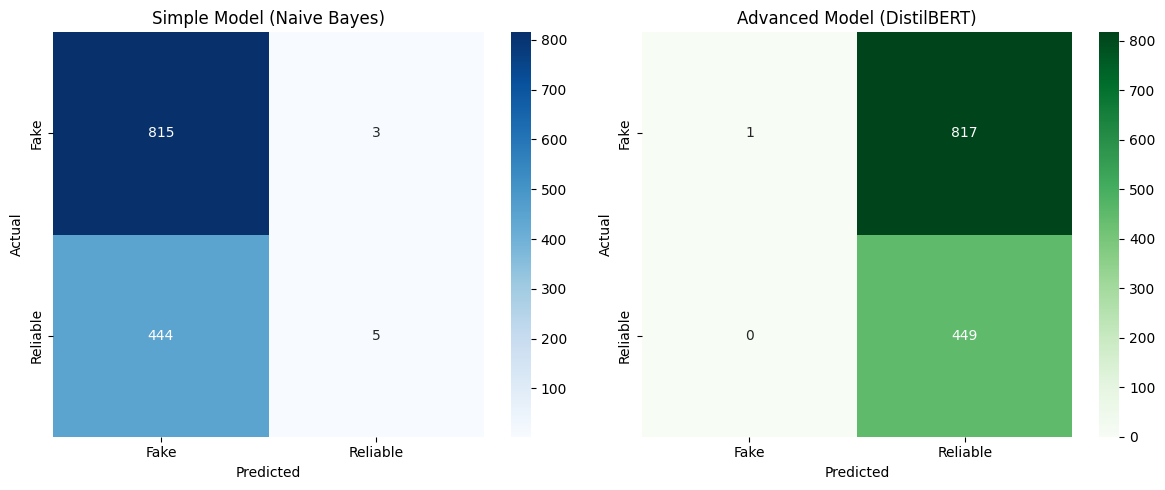

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrices
simple_cm = [[815, 3],
             [444, 5]]

advanced_cm = [[1, 817],
               [0, 449]]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# simple model confusion matrix
sns.heatmap(simple_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Simple Model (Naive Bayes)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_xticklabels(['Fake', 'Reliable'])
axes[0].set_yticklabels(['Fake', 'Reliable'])

# advanced model confusion matrix
sns.heatmap(advanced_cm, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Advanced Model (DistilBERT)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_xticklabels(['Fake', 'Reliable'])
axes[1].set_yticklabels(['Fake', 'Reliable'])

plt.tight_layout()
plt.show()


### Step 4: Training with Hugging Face Trainer on LIAR Dataset

In [72]:
# Split into train/val
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(liar_test, test_size=0.2, stratify=liar_test["label"], random_state=42)

# Dataset class
class LiarDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=64):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
        self.labels = labels

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

    def __len__(self):
        return len(self.labels)

# Tokenizer + Datasets
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
train_dataset = LiarDataset(train_df["statement"].tolist(), train_df["label"].tolist(), tokenizer)
val_dataset = LiarDataset(val_df["statement"].tolist(), val_df["label"].tolist(), tokenizer)

# Load and Train DistilBERT
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

training_args = TrainingArguments(
    output_dir="./liar_test_finetuned",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_dir="./logs_liar_test"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

trainer.train()

print("Completed Retraining the advance model for Liar dataset")

{'train_runtime': 134.4855, 'train_samples_per_second': 22.597, 'train_steps_per_second': 1.428, 'train_loss': 0.5186451276143392, 'epoch': 3.0}
Completed Retraining the advance model for Liar dataset


### Step 5: For Liar dataset Load Fine-Tuned Model and Evaluate

In [70]:
# Reload the fine-tuned model
model_path = "liar_test_finetuned_model"
model = DistilBertForSequenceClassification.from_pretrained(model_path)
tokenizer = DistilBertTokenizerFast.from_pretrained(model_path)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


# Preprocessing
texts = liar_test["statement"].astype(str).tolist()
labels = liar_test["label"].astype(int).tolist()

# Tokenize
inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=64)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Prediction
with torch.no_grad():
    outputs = model(**inputs)
    preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()

# Evaluation
acc = accuracy_score(labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary', pos_label=1)
cm = confusion_matrix(labels, preds)
report = classification_report(labels, preds, target_names=["fake", "reliable"])

print("\n After retraining and fine-tuning the advance model Final Evaluation Report on test.tsv")
print(report)


 After retraining and fine-tuning the advance model Final Evaluation Report on test.tsv
              precision    recall  f1-score   support

        fake       0.87      0.87      0.87       818
    reliable       0.77      0.76      0.76       449

    accuracy                           0.83      1267
   macro avg       0.82      0.81      0.82      1267
weighted avg       0.83      0.83      0.83      1267



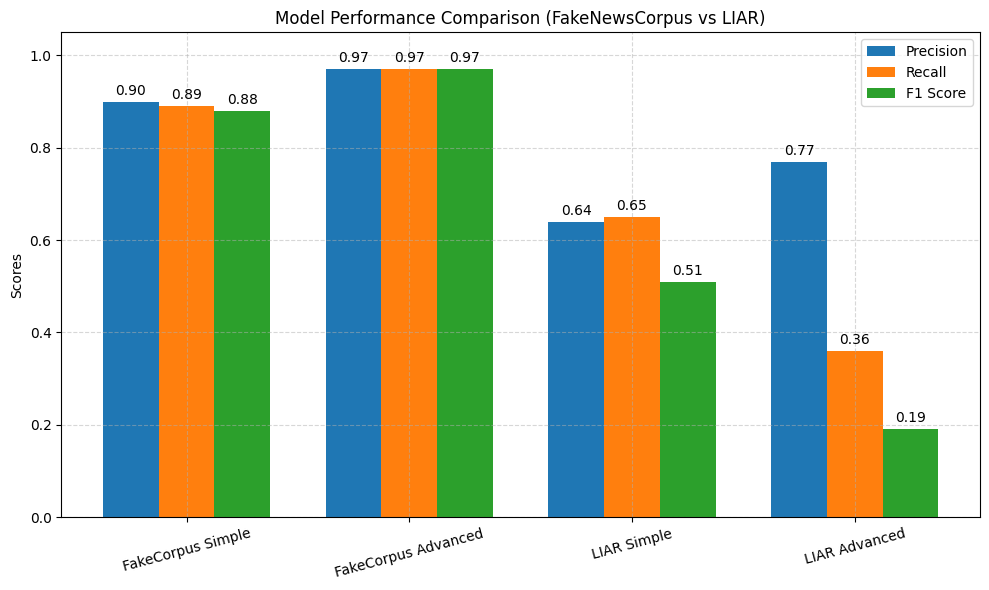

In [ ]:
import matplotlib.pyplot as plt

#weighted avg scores from classification report
scores = {
    "FakeCorpus Simple": {"precision": 0.90, "recall": 0.89, "f1": 0.88},   
    "FakeCorpus Advanced": {"precision": 0.97, "recall": 0.97, "f1": 0.97}, 
    "LIAR Simple": {"precision": 0.64, "recall": 0.65, "f1": 0.51},       
    "LIAR Advanced": {"precision": 0.77, "recall": 0.36, "f1": 0.19}        
}

# Plot Settings
labels = list(scores.keys())
precision_scores = [scores[m]["precision"] for m in labels]
recall_scores = [scores[m]["recall"] for m in labels]
f1_scores = [scores[m]["f1"] for m in labels]

x = np.arange(len(labels))
width = 0.25

# === Create Grouped Bar Chart ===
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width, precision_scores, width, label='Precision')
ax.bar(x, recall_scores, width, label='Recall')
ax.bar(x + width, f1_scores, width, label='F1 Score')

# === Labels and Legends ===
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison (FakeNewsCorpus vs LIAR)')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=15)
ax.set_ylim([0.0, 1.05])  # Increased from 1.0 to 1.05
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)

# === Annotate Bars ===
for i in range(len(labels)):
    ax.text(x[i] - width, precision_scores[i] + 0.015, f"{precision_scores[i]:.2f}", ha='center')
    ax.text(x[i], recall_scores[i] + 0.015, f"{recall_scores[i]:.2f}", ha='center')
    ax.text(x[i] + width, f1_scores[i] + 0.015, f"{f1_scores[i]:.2f}", ha='center')

plt.tight_layout()
plt.show()
